UBFC-Phys is a multimodal psychophysiology dataset (56 subjects) designed to analyze physiological responses under social stress. Each subject performs three tasks while being recorded by video + wristband sensors (BVP, EDA). Stress difficulty level (test vs ctrl) is randomly assigned. Anxiety/self-confidence scores are collected before and after the experiment.

Tasks (per subject)

| Task       | Code | Type     | Purpose                    |
| ---------- | ---- | -------- | -------------------------- |
| Rest       | T1   | Baseline | No stress                  |
| Speech     | T2   | Stress   | Social-evaluation stressor |
| Arithmetic | T3   | Stress   | Cognitive-load stressor    |

Each subject has three BVP files and three EDA files: T1, T2, T3.

Target Variables  
3. Psychological Measures (labels)

Collected twice: Pre-Experience and Post-Experience.

| Measure           | | Pre-Experience | Post-Experience |
| ----------------- | --------------------------------- | -------------- | --------------- |
| Cognitive anxiety | | value₁         | value₂          |
| Somatic anxiety   | | value₃         | value₄          |
| Self-confidence   | | value₅         | value₆          |


In [2]:
# IMPORTS & CONFIG
import os, json, warnings, traceback
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import joblib, pickle
import re
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.stats import pearsonr, ttest_ind

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')


In [3]:
# Paths
ROOT = Path('/teamspace/studios/this_studio/ubfc_testing')
DATA_PATH = ROOT / 'ubfc_2'
MODEL_PATH = ROOT / 'extratrees_wrist_all.pkl'
SCALER_PATH = ROOT / 'scaler_wrist_all.pkl'
OUT_DIR = ROOT / 'output'

In [4]:
# Check available subjects(will be called in full run)
subs = []
for p in sorted(DATA_PATH.glob('s*')):
    if p.is_dir():
        sid = re.sub(r'[^0-9]', '', p.name)
        if sid:
            # require at least one BVP file to exist
            bvp_files = list(p.glob('bvp_*_T*.csv'))
            if bvp_files:
                subs.append(sid)
SUBJECT_IDS = subs
TASKS = ['T1','T2','T3']
print('Subjects discovered:', SUBJECT_IDS)
print('N subjects =', len(SUBJECT_IDS), '| Tasks =', TASKS)

Subjects discovered: ['10', '11', '12', '13', '14', '15', '16', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '40', '41', '42', '6', '7', '8', '9']
N subjects = 24 | Tasks = ['T1', 'T2', 'T3']


In [5]:
# Dataset parameters
SAMPLING_RATE = 64  # UBFC BVP is 64 Hz.
WINDOW_SIZE_SEC = 120  
WINDOW_STEP_SEC = 60  
TASKS = ['T1','T2','T3']
SUBJECTS = [6,7,8,9,10,11,12,13,14,15,16,29,30,31,32,33,34,35,36,37,40,41,42]
LABEL_MAP = {'T1':0, 'T2':1, 'T3':1}  # Binary labels(cognitive and social stress are bundled)
scenario_map = {'T1':'ctrl','T2':'test','T3':'test'}

# Model expects 5 core features (confirmed from MMASH and scaler.n_features_in_)
CORE5 = ['SDNN','RMSSD','pNN50','Mean_RR','HR_mean']
print('Config OK:', DATA_PATH.exists(), MODEL_PATH.exists(), SCALER_PATH.exists())

Config OK: True True True


In [6]:
def load_model(path: Path):
    try:
        obj = joblib.load(path)
        print(f'[joblib] Loaded {path.name}:', type(obj).__name__)
        return obj
    except Exception as e:
        print(f'[joblib] Failed for {path.name}: {e}; trying pickle...')
        with open(path, 'rb') as f:
            obj = pickle.load(f)
        print(f'[pickle] Loaded {path.name}:', type(obj).__name__)
        return obj

model = load_model(MODEL_PATH)
scaler = load_model(SCALER_PATH)

[joblib] Loaded extratrees_wrist_all.pkl: ExtraTreesClassifier
[joblib] Loaded scaler_wrist_all.pkl: StandardScaler


In [7]:
# Inspect scaler to infer expected feature count
n_in = getattr(scaler, 'n_features_in_', None)
print('Scaler n_features_in_(Should have 5 features) =', n_in)

Scaler n_features_in_(Should have 5 features) = 5


In [8]:
# UTILS: BVP -> RR

def load_bvp(path: Path):
    return pd.read_csv(path, header=None).values.flatten()

def clean_bvp(x, fs=SAMPLING_RATE):
    return nk.ppg_clean(x, sampling_rate=fs)

def detect_peaks(cleaned, fs=SAMPLING_RATE):
    pk = nk.ppg_peaks(cleaned, sampling_rate=fs)[1]['PPG_Peaks']
    return pk

def rr_from_peaks(peaks, fs=SAMPLING_RATE):
    # RR in ms from peak index differences
    rr_samples = np.diff(peaks)
    return (rr_samples / fs) * 1000.0

def filter_rr(rr_ms, min_rr=300, max_rr=2000):
    rr = np.asarray(rr_ms).flatten()
    mask = (rr >= min_rr) & (rr <= max_rr)
    return rr[mask]

def quick_plots(bvp, cleaned, peaks, rr, rr_filt, title_prefix=''):
    t = np.arange(len(bvp))/SAMPLING_RATE
    fig, axes = plt.subplots(2,2, figsize=(14,8))
    axes[0,0].plot(t, bvp, lw=0.5); axes[0,0].set_title(f'{title_prefix} Raw BVP')
    axes[0,1].plot(t, cleaned, lw=0.5); axes[0,1].scatter(t[peaks], cleaned[peaks], s=10, c='r'); axes[0,1].set_title('Cleaned + Peaks')
    axes[1,0].plot(rr, marker='o', lw=0.8); axes[1,0].axhline(300,color='r',ls='--'); axes[1,0].axhline(2000,color='r',ls='--'); axes[1,0].set_title('RR (ms)')
    axes[1,1].plot(rr_filt, marker='o', lw=0.8); axes[1,1].set_title('RR filtered (ms)')
    plt.tight_layout(); plt.show()
    print('Peaks:', len(peaks), '| RR:', len(rr), '| RR_filtered:', len(rr_filt))

print('BVP→RR utilities ready.')

BVP→RR utilities ready.


In [9]:
# WINDOWING on RR(using the 120 from MMASH)

def extract_windows(rr_ms, window_size_sec=WINDOW_SIZE_SEC, step_size_sec=WINDOW_STEP_SEC):
    rr = np.asarray(rr_ms).flatten()
    if rr.size == 0:
        return [], []
    beats_sec = np.cumsum(np.concatenate([[0], rr/1000.0]))  # beat times in sec
    total = beats_sec[-1]
    windows, meta = [], []
    start, idx = 0.0, 0
    while start + window_size_sec <= total + 1e-6:
        end = start + window_size_sec
        mask = (beats_sec[:-1] >= start) & (beats_sec[1:] < end)
        seg = rr[mask]
        if seg.size >= 2:
            windows.append(seg)
            meta.append({'window_index': idx, 'start_sec': float(start), 'end_sec': float(end), 'rr_count': int(seg.size)})
        idx += 1
        start += step_size_sec
    return windows, meta

In [10]:
# METADATA LOADERS(used only for reporting purposes not for val)

def load_subject_info(subject_id, base=DATA_PATH):
    sid = str(subject_id)
    base_dir = Path(base) / f's{sid}'
    candidates = [base_dir / f'info_s{sid}.txt', base_dir / f'infos_{sid}.txt']
    target = None
    for c in candidates:
        if c.exists(): target = c; break
    if target is None:
        return {'subject_id': sid, 'gender': np.nan, 'scenario': 'unknown', 'date': np.nan, 'time': np.nan}
    lines = []
    with open(target, 'r', encoding='utf-8', errors='ignore') as f:
        for raw in f.readlines():
            s = raw.strip()
            if s: lines.append(s)
            if len(lines) >= 5: break
    while len(lines) < 5: lines.append(np.nan)
    subj, gender, scenario, date, t = lines[:5]
    return {'subject_id': sid, 'gender': gender, 'scenario': scenario, 'date': date, 'time': t}


def load_self_reported_anxiety(subject_id, base=DATA_PATH):
    sid = str(subject_id)
    fpath = Path(base) / f's{sid}' / f'selfReportedAnx_s{sid}.csv'
    if not fpath.exists():
        return {'subject_id': sid, 'cognitive_pre': np.nan, 'cognitive_post': np.nan, 'cognitive_change': np.nan,
                'somatic_pre': np.nan, 'somatic_post': np.nan, 'somatic_change': np.nan,
                'confidence_pre': np.nan, 'confidence_post': np.nan, 'confidence_change': np.nan}
    df = pd.read_csv(fpath, header=None).astype(float)
    cog_pre, cog_post = df.iloc[0].tolist()
    som_pre, som_post = df.iloc[1].tolist()
    con_pre, con_post = df.iloc[2].tolist()
    return {'subject_id': sid,
            'cognitive_pre': cog_pre, 'cognitive_post': cog_post, 'cognitive_change': cog_post-cog_pre,
            'somatic_pre': som_pre, 'somatic_post': som_post, 'somatic_change': som_post-som_pre,
            'confidence_pre': con_pre, 'confidence_post': con_post, 'confidence_change': con_post-con_pre}

print('Metadata loaders ready.')

Metadata loaders ready.


In [11]:
# HRV extraction for a window + mapping to 
def hrv_from_rr_window(rr_ms, fs=SAMPLING_RATE):
    rr = np.asarray(rr_ms).flatten()
    if rr.size < 2: return None
    rr_sec = rr / 1000.0
    peaks = np.round(np.cumsum(np.concatenate([[0], rr_sec])) * fs).astype(int)
    try:
        hrv = nk.hrv(peaks=peaks, sampling_rate=fs, show=False)
        return hrv
    except Exception as e:
        print('[HRV] extraction failed:', e)
        return None


def map_to_core5(hrv_df, rr_ms_window):
    # SDNN <- HRV_SDNN; RMSSD <- HRV_RMSSD; pNN50 <- HRV_pNN50; Mean_RR <- HRV_MeanNN; HR_mean <- 60000/Mean_RR
    if hrv_df is None or hrv_df.empty:
        return None
    row = hrv_df.iloc[0]
    try:
        mean_rr = float(row.get('HRV_MeanNN', np.nan))
        hr_mean = 60000.0/mean_rr if mean_rr and np.isfinite(mean_rr) and mean_rr>0 else np.nan
        core = {
            'SDNN': float(row.get('HRV_SDNN', np.nan)),
            'RMSSD': float(row.get('HRV_RMSSD', np.nan)),
            'pNN50': float(row.get('HRV_pNN50', np.nan)),
            'Mean_RR': mean_rr,
            'HR_mean': hr_mean,
        }
        return core
    except Exception as e:
        print('[CORE5] mapping failed:', e)
        return None

print('HRV + CORE5 mapping ready.')

HRV + CORE5 mapping ready.


In [12]:
# PROCESS ONE TASK FILE (returns per-window CORE5 rows + metadata).

def process_task_file(subject_id, task, base=DATA_PATH, fs=SAMPLING_RATE, plot=True):
    sid = str(subject_id)
    path = Path(base)/f's{sid}'/f'bvp_s{sid}_{task}.csv'
    if not path.exists():
        print('[SKIP] missing', path)
        return pd.DataFrame(), {'subject_id': sid, 'task': task, 'windows': 0}
    bvp = load_bvp(path)
    cleaned = clean_bvp(bvp, fs)
    peaks = detect_peaks(cleaned, fs)
    rr = rr_from_peaks(peaks, fs)
    rr_f = filter_rr(rr)
    if plot:
        quick_plots(bvp, cleaned, peaks, rr, rr_f, title_prefix=f's{sid} {task}')
    wins, meta = extract_windows(rr_f)
    rows = []
    for m, rr_w in zip(meta, wins):
        hrv = hrv_from_rr_window(rr_w, fs)
        core = map_to_core5(hrv, rr_w)
        if core is None:
            continue
        core.update({
            'subject_id': sid, 'task': task, 'label': LABEL_MAP[task],
            'window_index': m['window_index'], 'window_start_sec': m['start_sec'], 'window_end_sec': m['end_sec'],
            'rr_count_window': m['rr_count']
        })
        core['RR_mean_ms_window'] = float(np.mean(rr_w)) if len(rr_w) else np.nan
        core['RR_sd_ms_window'] = float(np.std(rr_w)) if len(rr_w) else np.nan
        rows.append(core)
    df = pd.DataFrame(rows, columns=CORE5 + ['subject_id','task','label','window_index','window_start_sec','window_end_sec','rr_count_window','RR_mean_ms_window','RR_sd_ms_window'])
    summary = {'subject_id': sid, 'task': task, 'signal_sec': len(bvp)/fs, 'peaks': int(len(peaks)), 'rr_total': int(len(rr)), 'rr_filtered': int(len(rr_f)), 'windows': int(df.shape[0])}
    return df, summary

print('Single task processor ready.')

Single task processor ready.


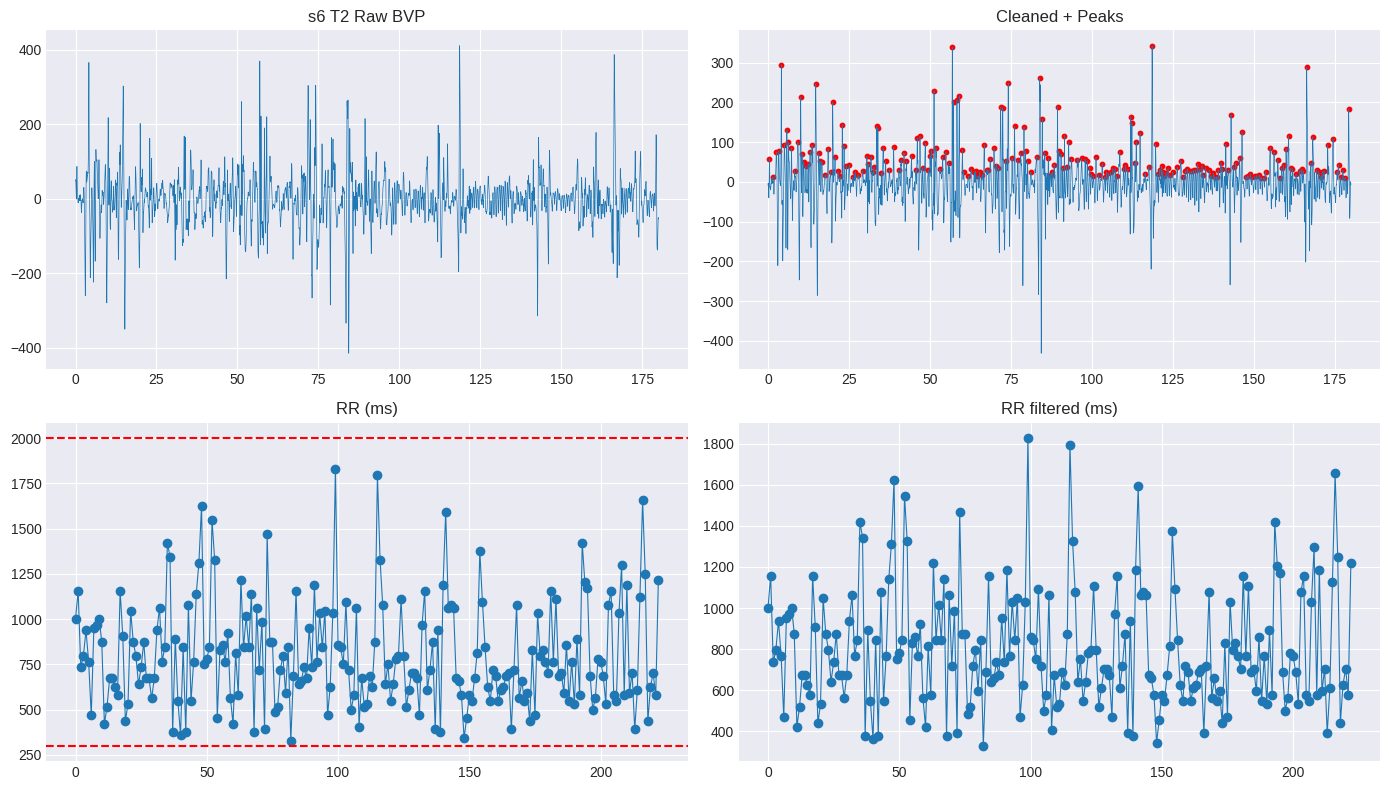

Peaks: 224 | RR: 223 | RR_filtered: 223
Summary: {'subject_id': '6', 'task': 'T2', 'signal_sec': 180.0, 'peaks': 224, 'rr_total': 223, 'rr_filtered': 223, 'windows': 1}


,SDNN,RMSSD,pNN50,Mean_RR,HR_mean,subject_id,task,label,window_index,window_start_sec,window_end_sec,rr_count_window,RR_mean_ms_window,RR_sd_ms_window
0,294.897409,383.495279,86.986301,821.275685,73.057076,6,T2,1,0,0.0,120.0,146,821.275685,293.885752


In [13]:
# DEMO on one subject-task 
demo_sid, demo_task = 6, 'T2'
demo_df, demo_sum = process_task_file(demo_sid, demo_task, plot=True)
print('Summary:', demo_sum)
display(demo_df.head())

In [14]:
# BATCH PROCESS ALL SUBJECTS & TASKS

def batch_process_all(subjects=SUBJECTS, tasks=TASKS, base=DATA_PATH):
    rows = []
    summaries = []
    sr_rows = []
    for sid in subjects:
        info = load_subject_info(sid, base)
        sr = load_self_reported_anxiety(sid, base)
        for t in tasks:
            df_w, sum_w = process_task_file(sid, t, base=base, plot=False)
            if not df_w.empty:
                for k,v in info.items():
                    df_w[k] = v
                for k,v in sr.items():
                    if k != 'subject_id': df_w[k] = v
                rows.append(df_w)
            sum_w['windows_kept'] = 0 if df_w.empty else int(df_w.shape[0])
            summaries.append(sum_w)
        sr_rows.append(sr)
    full = pd.concat(rows, axis=0).reset_index(drop=True) if rows else pd.DataFrame()
    summary_df = pd.DataFrame(summaries)
    sr_df = pd.DataFrame(sr_rows).drop_duplicates('subject_id')
    return full, summary_df, sr_df

features_df, task_summary_df, self_reports_df = batch_process_all()
print('features_df shape:', features_df.shape)
display(task_summary_df.head())
display(self_reports_df.head())

# Distribution
print('Label distribution:', features_df['label'].value_counts().to_dict())
print('Scenario counts:', features_df['scenario'].value_counts(dropna=False).to_dict())

features_df shape: (68, 27)


,subject_id,task,signal_sec,peaks,rr_total,rr_filtered,windows,windows_kept
0,6,T1,180.0,266,265,265,1,1
1,6,T2,180.0,224,223,223,1,1
2,6,T3,180.0,290,289,289,1,1
3,7,T1,180.0,211,210,210,1,1
4,7,T2,180.0,215,214,213,1,1


,subject_id,cognitive_pre,cognitive_post,cognitive_change,somatic_pre,somatic_post,somatic_change,confidence_pre,confidence_post,confidence_change
0,6,1.571,1.286,-0.285,2.000,2.428,0.428,2.111,2.444,0.333
1,7,2.000,1.714,-0.286,1.714,1.571,-0.143,2.222,2.000,-0.222
2,8,1.857,2.000,0.143,1.428,1.571,0.143,3.222,2.778,-0.444
3,9,3.714,3.286,-0.428,2.428,3.000,0.572,1.778,1.333,-0.445
4,10,2.143,2.714,0.571,1.714,2.428,0.714,2.222,1.778,-0.444


Label distribution: {1: 46, 0: 22}
Scenario counts: {'test': 35, 'ctrl': 30, 'unknown': 3}


In [15]:
# Persist preprocessed files 
features_path = OUT_DIR / 'ubfc_features_core5.csv'
task_sum_path = OUT_DIR / 'ubfc_task_summaries.csv'
sr_path = OUT_DIR / 'ubfc_self_reports.csv'
features_df.to_csv(features_path, index=False)
task_summary_df.to_csv(task_sum_path, index=False)
self_reports_df.to_csv(sr_path, index=False)
print('Saved:', features_path, task_sum_path, sr_path)

Saved: /teamspace/studios/this_studio/ubfc_testing/output/ubfc_features_core5.csv /teamspace/studios/this_studio/ubfc_testing/output/ubfc_task_summaries.csv /teamspace/studios/this_studio/ubfc_testing/output/ubfc_self_reports.csv


In [16]:
def validate_model(df, model, scaler):
    X = df[CORE5].copy().fillna(0.0)
    y = df['label'].astype(int).values
    Xs = scaler.transform(X)
    y_pred = model.predict(Xs)
    y_map = y_pred.copy()
    if 2 in np.unique(y_map):
        y_map[y_map==2] = 0
    y_bin = (y_pred >= 1).astype(int)
    acc = accuracy_score(y, y_bin)
    f1m = f1_score(y, y_bin, average='macro')
    cm = confusion_matrix(y, y_bin)
    res = df.copy()
    res['pred_raw'] = y_pred
    res['pred_bin'] = y_bin
    res['correct'] = (y_bin==y).astype(int)
    return res, acc, f1m, cm

In [17]:
results_df, acc, f1, cm = validate_model(features_df, model, scaler)
print(f'Accuracy={acc:.4f} | F1={f1:.4f}')
print('CM (rows=true, cols=pred_bin):')
print(cm)
out_res = OUT_DIR / 'ubfc_results.csv'
results_df.to_csv(out_res, index=False)
print('Saved results ->', out_res)

Accuracy=0.6912 | F1=0.6650
CM (rows=true, cols=pred_bin):
[[14  8]
 [13 33]]
Saved results -> /teamspace/studios/this_studio/ubfc_testing/output/ubfc_results.csv


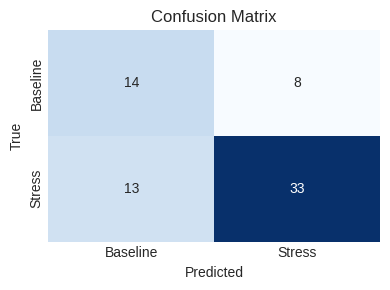

In [18]:
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Baseline','Stress'], yticklabels=['Baseline','Stress'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

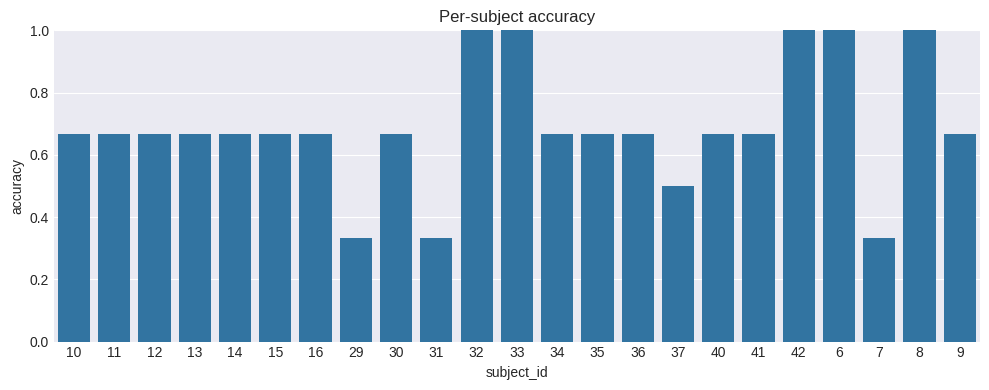

In [19]:
ps = results_df.groupby('subject_id')['correct'].mean().reset_index().rename(columns={'correct':'accuracy'})
plt.figure(figsize=(10,4))
sns.barplot(data=ps, x='subject_id', y='accuracy')
plt.ylim(0,1); plt.title('Per-subject accuracy'); plt.tight_layout(); plt.show()

In [20]:
summ_path = OUT_DIR / 'ubfc_task_summaries.csv'

if summ_path.exists():
    task_summ = pd.read_csv(summ_path)
    task_summ['subject_id'] = task_summ['subject_id'].astype(str)
    results_df['subject_id'] = results_df['subject_id'].astype(str)
    # Use scenario if present; else derive from task
    if 'scenario' in task_summ.columns:
        cols = ['subject_id','task','scenario']
        task_summ = task_summ[cols].drop_duplicates()
    else:
        task_summ = task_summ[['subject_id','task']].drop_duplicates()
        task_summ['scenario'] = task_summ['task'].map(scenario_map).fillna('unknown')
    results_ext = results_df.merge(task_summ, on=['subject_id','task'], how='left')
else:
    results_ext = results_df.copy()

# Final: if scenario missing, derive from task
if 'scenario' not in results_ext.columns:
    results_ext['scenario'] = results_ext['task'].map(scenario_map).fillna('unknown')


By task:
  task   n  accuracy        f1                 cm
0   T1  22  0.636364  0.388889  [[14, 8], [0, 0]]
1   T2  23  0.782609  0.439024  [[0, 0], [5, 18]]
2   T3  23  0.652174  0.394737  [[0, 0], [8, 15]]


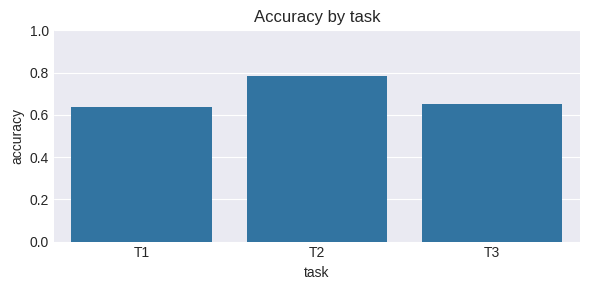

In [21]:
# By task
by_task = []
for t in ['T1','T2','T3']:
    d = results_ext[results_ext['task']==t]
    if len(d)==0:
        continue
    acc_t = (d['correct'].mean() if 'correct' in d else (d['label'].values==(d['pred_bin'].values)).mean())
    f1_t = f1_score(d['label'], d['pred_bin'], average='macro')
    cm_t = confusion_matrix(d['label'], d['pred_bin'])
    by_task.append({'task':t,'n':len(d),'accuracy':float(acc_t),'f1':float(f1_t),'cm':cm_t.tolist()})
by_task_df = pd.DataFrame(by_task)
print('By task:')
print(by_task_df)

plt.figure(figsize=(6,3))
sns.barplot(data=by_task_df, x='task', y='accuracy')
plt.ylim(0,1); plt.title('Accuracy by task'); plt.tight_layout(); plt.show()


By scenario:
  scenario   n  accuracy  f1_macro                  cm
0     ctrl  22  0.636364  0.388889   [[14, 8], [0, 0]]
1     test  46  0.717391  0.417722  [[0, 0], [13, 33]]


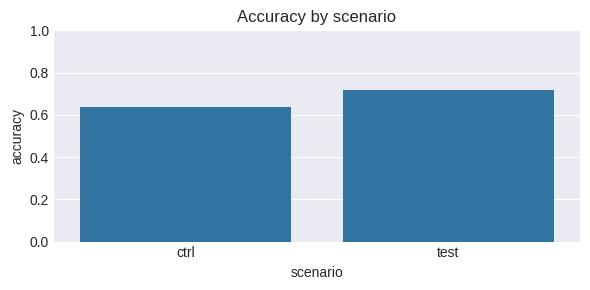

In [22]:
# By scenario
by_scen = []
for s, d in results_ext.groupby('scenario'):
    acc_s = (d['correct'].mean() if 'correct' in d else (d['label'].values==(d['pred_bin'].values)).mean())
    f1_s = f1_score(d['label'], d['pred_bin'], average='macro')
    cm_s = confusion_matrix(d['label'], d['pred_bin'])
    by_scen.append({'scenario':s,'n':len(d),'accuracy':float(acc_s),'f1_macro':float(f1_s),'cm':cm_s.tolist()})
by_scen_df = pd.DataFrame(by_scen)
print('By scenario:')
print(by_scen_df)

plt.figure(figsize=(6,3))
sns.barplot(data=by_scen_df, x='scenario', y='accuracy')
plt.ylim(0,1); plt.title('Accuracy by scenario'); plt.tight_layout(); plt.show()


In [23]:
# Save JSON summary
summary = {
    'tier1': {
        'overall': {
            'accuracy': float(acc),
            'f1': float(f1),
            'confusion_matrix': cm.tolist(),
            'n': int(len(results_df))
        },
        'by_task': by_task,
        'by_scenario': by_scen
    }
}
sum_path = OUT_DIR / 'ubfc_val_summary.json'
with open(sum_path, 'w') as f:
    json.dump(summary, f, indent=2)
print('Saved summary ->', sum_path)

Saved summary -> /teamspace/studios/this_studio/ubfc_testing/output/ubfc_val_summary.json
